# W2(II)_Implementing Locality Sensitive Hashing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from copy import copy
from itertools import combinations
import time

In [2]:
# compute norm of a sparse vector
def norm(x):
    norm = np.sqrt(np.dot(x, x.T))
    return norm

In [3]:
data = pd.read_csv('people_wiki.csv')
data['index'] = np.array(range(len(data)))
col = ['index', 'name', 'text']
data = data[col]
data.head()

,index,name,text
0,0,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,2,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,4,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)

tf_idf_matrix = load_sparse_csr('people_wiki_tf_idf.npz')
tf_idf_matrix # sparse matrix with 59071 data points, 547979 features

<59071x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [5]:
word_index_ser = pd.read_json('people_wiki_map_index_to_word.json', typ='series')
word_index_dic = dict(word_index_ser)

def unpack_dict(matrix, word_index_dic):
    table = sorted(word_index_dic, key=word_index_dic.get)
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    num_doc = matrix.shape[0]
    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]]], data[indptr[i]:indptr[i+1]].tolist())} for i in range(num_doc)]

data['word_count'] = unpack_dict(tf_idf_matrix, word_index_dic)
data.head()

,index,name,text,word_count
0,0,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 10.986495389225194, 'phasede..."
2,2,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 10.986495389225194, 'bluesgosp..."
3,3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 10.986495389225194,..."
4,4,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 32.95948616767558, 'gangstergenka': 1..."


In [6]:
def generate_random_vectors(num_dim, num_bin):
    return np.random.randn(num_dim, num_bin)

In [7]:
def LSH_model(data, num_bin=16, seed=None):
    if seed is not None:
        np.random.seed(seed)

    dim = data.shape[1]
    random_vectors = generate_random_vectors(dim, num_bin) # dim * bin
    powers_of_two = 2 ** np.arange(num_bin-1, -1, -1) # bin * 1
     
    # partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0) # n * bin
  
    # encode bin index bits into integers
    bin_indexes = bin_index_bits.dot(powers_of_two) # n * 1
    
    table = {}
    for data_index, bin_index in enumerate(bin_indexes):
        if bin_index not in table:
            table[bin_index] = []
        table[bin_index].append(data_index)
            
    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indexes': bin_indexes,
             'table': table,
             'random_vectors': random_vectors,
             'num_bin': num_bin}
    
    return model

In [8]:
model = LSH_model(tf_idf_matrix, num_bin=16, seed=143)

In [9]:
def consine_distance(a ,b):
    # a, b are sparse matrix
    ab = a.dot(b.T)
    dist = ab / (norm(a) * norm(b)) 
    return 1 - dist[0,0]

In [10]:
a = tf_idf_matrix[35817,:]
b = tf_idf_matrix[24478,:]
consine_distance(a, b)

0.70313867673357477

In [11]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    num_bin = len(query_bin_bits)
    powers_of_two = 2 ** np.arange(num_bin-1, -1, -1)
    candidate_set = copy(initial_candidates)
    
    for changed_bits in combinations(range(num_bin), search_radius):       
        nearby_bin_bits = copy(query_bin_bits)
        for i in changed_bits:
            nearby_bin_bits[i] = not(nearby_bin_bits[i]) # flip the bit
        
        nearby_bin_index = nearby_bin_bits.dot(powers_of_two)
        
        if nearby_bin_index in table:
            candidate_set.update(set(table[nearby_bin_index]))            
            
    return candidate_set

In [12]:
obama_bin_bits = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_bits, model['table'], search_radius=0)
print('# search radius=0')
print(candidate_set)
print('----------')
print('# search radius=1')
candidate_set = search_nearby_bins(obama_bin_bits, model['table'], search_radius=1, initial_candidates=candidate_set)
print(candidate_set)

# search radius=0
{39426, 35817, 53937, 21426, 50261}
----------
# search radius=1
{39426, 38155, 38412, 27404, 28444, 9757, 47773, 41631, 39207, 59050, 53937, 21426, 23229, 55615, 39877, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676, 19699, 2804, 34547, 20347}


In [13]:
def query(query_vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_bin = random_vectors.shape[1]
    
    bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()
    
    # search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    # sort candidates by their true distances from the query
    
    nearest_neighbors = pd.DataFrame({'index':list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'])[:k], len(candidate_set)

In [14]:
NN_result, num_candidates = query(tf_idf_matrix[35817,:], model, k=10, max_search_radius=3)

In [15]:
NN_result.join(data[['index', 'name']], on='index', lsuffix='1').drop('index1', axis=1)

,distance,index,name
555,0.000000,35817,Barack Obama
715,0.703139,24478,Joe Biden
495,0.856848,56008,Nathan Cullen
61,0.874669,37199,Barry Sullivan (lawyer)
623,0.890034,40353,Neil MacBride
180,0.898377,9267,Vikramaditya Khanna
474,0.899340,55909,Herman Cain
167,0.900921,9165,Raymond F. Clevenger
109,0.903003,57958,Michael J. Malbin
128,0.909533,49872,Lowell Barron


In [16]:
# effect of nearby bin search
# elements we care: number of candidate documents considered, query time, distance of approximate neighbors from the query

num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    NN_result, num_candidates = query(tf_idf_matrix[35817,:], model, k=10, max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # measure time
    
    print('Radius:', max_search_radius)
    print(NN_result.join(data[['index', 'name']], on='index', lsuffix='1').drop('index1', axis=1))
    
    average_distance_from_query = NN_result['distance'][1:].mean()
    max_distance_from_query = NN_result['distance'][1:].max()
    min_distance_from_query = NN_result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
   distance  index                     name
1  0.000000  35817             Barack Obama
3  0.950867  21426            Mark Boulware
0  0.975966  39426  John Wells (politician)
4  0.978256  50261        Francis Longstaff
2  0.993092  53937    Madurai T. Srinivasan
Radius: 1
    distance  index                                   name
21  0.000000  35817                           Barack Obama
7   0.947459  41631                            Binayak Sen
11  0.950867  21426                          Mark Boulware
19  0.951766  33243                        Janice Lachance
15  0.960859  33996                            Rufus Black
4   0.961081  28444                       John Paul Phelan
26  0.974130  20347                        Gianni De Fraja
0   0.975966  39426                John Wells (politician)
25  0.978215  34547  Nathan Murphy (Australian politician)
17  0.978256  50261                      Francis Longstaff
Radius: 2
     distance  index                 name
147  0.000000  

Radius: 16
       distance  index                     name
35817  0.000000  35817             Barack Obama
24478  0.703139  24478                Joe Biden
38376  0.742982  38376           Samantha Power
57108  0.758358  57108   Hillary Rodham Clinton
38714  0.770561  38714  Eric Stern (politician)
46140  0.784678  46140             Robert Gibbs
6796   0.788039   6796              Eric Holder
44681  0.790926  44681   Jesse Lee (politician)
18827  0.798323  18827             Henry Waxman
2412   0.799466   2412          Joe the Plumber


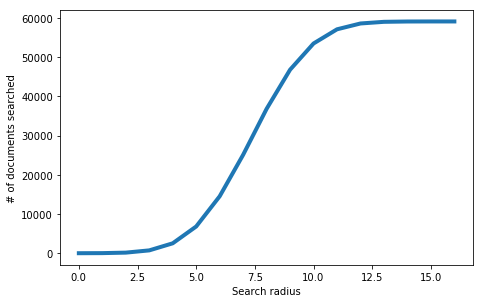

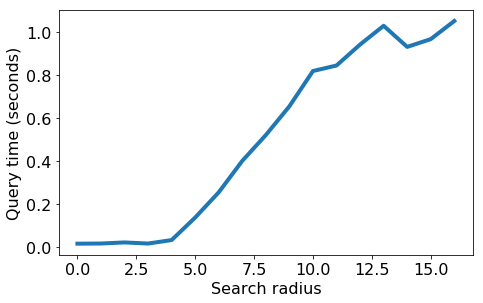

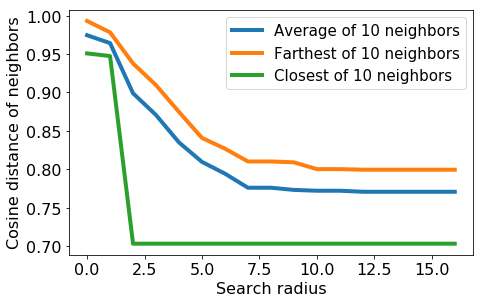

In [17]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()